In [1]:
import sys
import random; random.seed(90)
import numpy as np
from collections import defaultdict
from IPython.display import clear_output

from utils import plot_blackjack_values, plot_policy
from blackjack import BlackjackEnv

In [2]:
# init the environment
env = BlackjackEnv()

In [3]:
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


## Play with a Random Policy

In [4]:
for i_episode in range(3):

    state = env.reset()
    print('-------------------')
    print(f'PLAY EPISODE {i_episode+1}')
    print('-------------------')
    while True:
        action = env.action_space.sample() # random policy
        next_state, reward, done, info = env.step(action)
        print('Player\'s card:', state[0])
        print('Dealer\'s card:', state[1])
        print('Any ace:', state[2])
        if action == 1: # 1 for draw and 0 for stick
            if next_state[0] > 21:
                print(f'Random action: {action} -> Next card: {next_state[0]} (Bust!)')
            else:
                print(f'Random action: {action} -> Next card: {next_state[0]}')
        else:
            print(f'Random action: {action}')
        state = next_state
        print('-------------------')
        if done:
            print('End game\'s reward:', reward)
            print('*You won :)\n') if reward > 0 else print('*You lost :(\n')
            break
            
print('*The reason of losts could be bust or dealer\'s sum card is more than player\'s own.')

-------------------
PLAY EPISODE 1
-------------------
Player's card: 20
Dealer's card: 6
Any ace: False
Random action: 1 -> Next card: 25 (Bust!)
-------------------
End game's reward: -1
*You lost :(

-------------------
PLAY EPISODE 2
-------------------
Player's card: 15
Dealer's card: 10
Any ace: False
Random action: 0
-------------------
End game's reward: 1.0
*You won :)

-------------------
PLAY EPISODE 3
-------------------
Player's card: 13
Dealer's card: 5
Any ace: False
Random action: 1 -> Next card: 22 (Bust!)
-------------------
End game's reward: -1
*You lost :(

*The reason of losts could be bust or dealer's sum card is more than player's own.


## Set Utils

In [5]:
def run_game(env, policy):
    
    state = env.reset()
    episode = []
    finished = False
    
    while not finished:            
        timestep = []
        timestep.append(state)
        action = policy[state]
        
        state, reward, finished, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)
        
        episode.append(timestep)
        
    return episode

In [6]:
def evaluate_policy(env, policy, num_episodes=100):
    wins = 0; loss = 0
    
    print('Now, the agent is playing...')
    for i in range(num_episodes):
        episode_reward = run_game(env, policy)[-1][-1]
        if episode_reward == 1:
            wins += 1
                
    return wins/ num_episodes

## Part 1: TD Prediction (Policy Evaluation)

In [7]:
def get_action_policy(state):
    
    player_score, dealer_score, usable_ace = state
    return np.array([1.0, 0.0]) if player_score >= 20 else np.array([0.0, 1.0])

In [8]:
# this function will evaluate state value function
def td_prediction(env, num_episodes, alpha, gamma=0.9):
    
    # init empty dictionaries of arrays
    V = defaultdict(float)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        done = False
        
        while True:
            probs = get_action_policy(state)
            action = np.random.choice(np.arange(env.action_space.n), p=probs)
            
            next_state, reward, done, _ = env.step(action)
            
            # apply TD prediction update rule
            TD_target = reward + gamma * V[next_state]
            TD_error = TD_target - V[state]
            V[state] = V[state] + (alpha * TD_error)
            
            if done:
                break
    return V

In [9]:
# obtain the action-value function
V = td_prediction(env, num_episodes=500000, alpha=.01)

Episode 500000/500000.

In [10]:
# obtain the corresponding state-value function
V_to_plot = dict((k, v) for k, v in V.items())

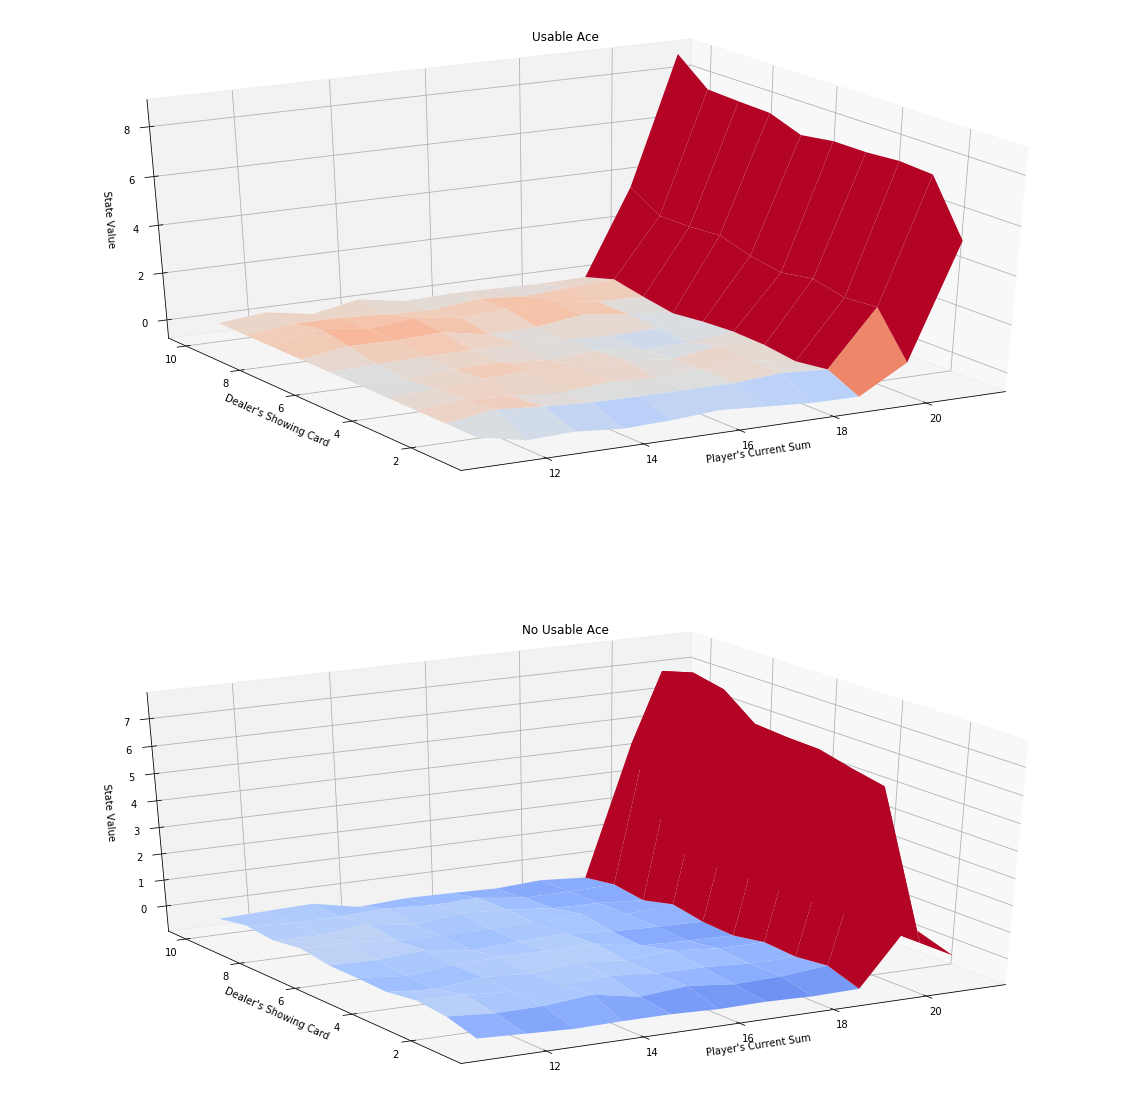

In [11]:
# plot the state-value function
plot_blackjack_values(V_to_plot)

## Part 2: TD Control (Policy Improvement): Sarsa

In [12]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current_value = Q[state][action] # estimate in Q-table for current state-action pair
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0 # get value of state-action at next time step
    
    TD_target = reward + (gamma * Qsa_next) # construct TD target
    TD_error = TD_target - current_value # construct TD error
    new_value = current_value + (alpha * (TD_error)) # apply update rule
    return new_value

In [13]:
def get_epsilon_greedy_action_policy(Q_s, epsilon, nA):
    """Obtains the action probabilities corresponding to epsilon-greedy policy."""
    policy_state = np.ones(nA) * epsilon / nA # epsilon 0 is guaranteed to always select the greedy action
    best_action = np.argmax(Q_s)
    policy_state[best_action] = 1 - epsilon + (epsilon / nA)
    
    return policy_state

In [14]:
def td_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        state = env.reset()
        
        epsilon = 1.0 / i_episode # set value of epsilon
        probs = get_epsilon_greedy_action_policy(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs)
        done = False
        
        while True:
            next_state, reward, done, _ = env.step(action)
            
            if not done:
                next_probs = get_epsilon_greedy_action_policy(Q[next_state], epsilon, nA)
                next_action = np.random.choice(np.arange(nA), p=next_probs)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action) # apply TD control update rule
                state = next_state
                action = next_action
                
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward) # apply TD control update rule
                break

    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [15]:
# obtain the estimated optimal policy and action-value function
optimal_policy, Q = td_control(env, num_episodes=500000, alpha=2e-2)

Episode 500000/500000.

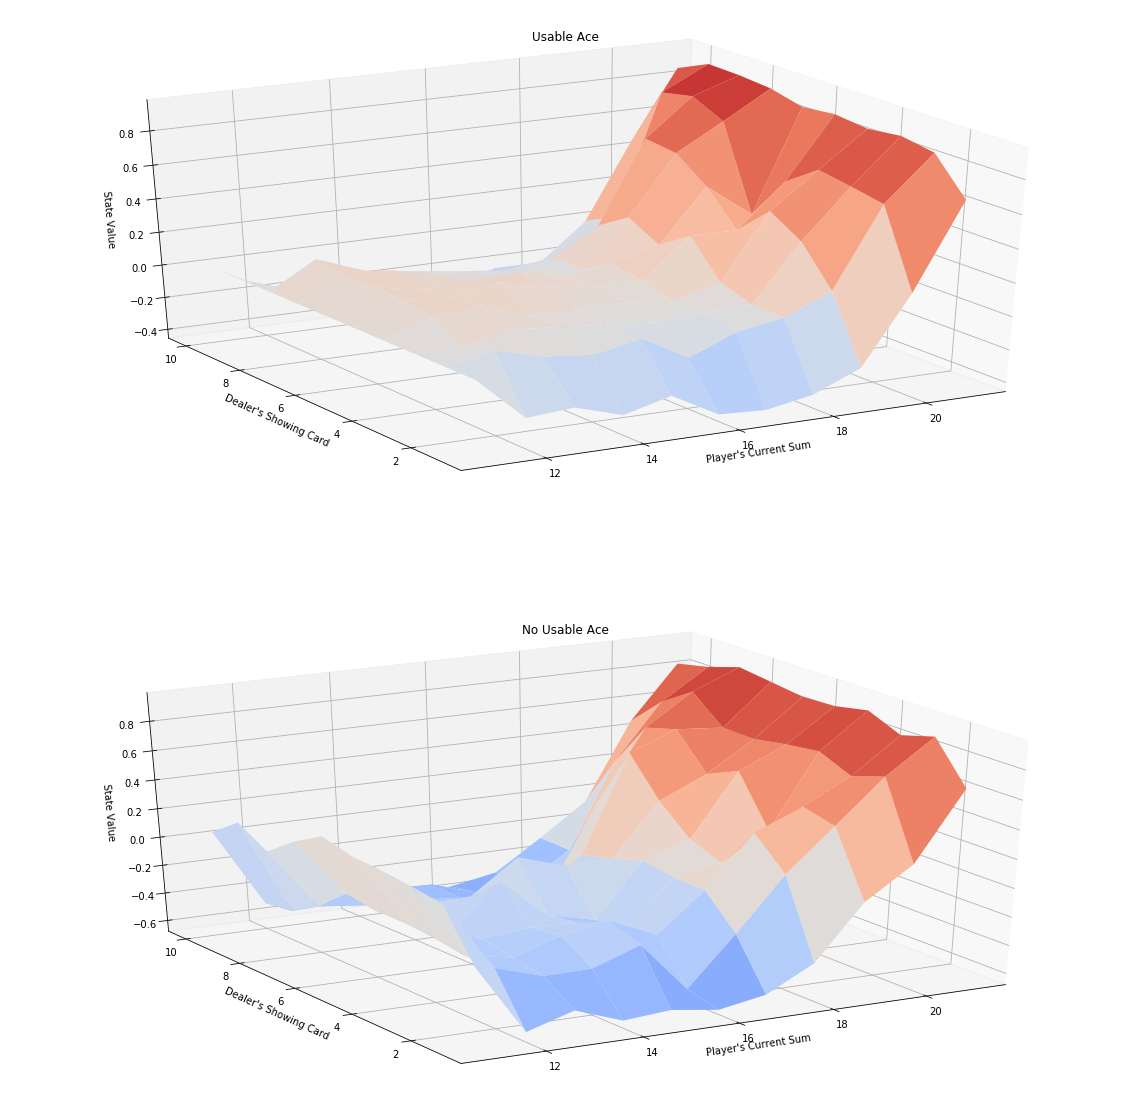

In [16]:
# obtain the corresponding state-value function
V = dict((k, np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

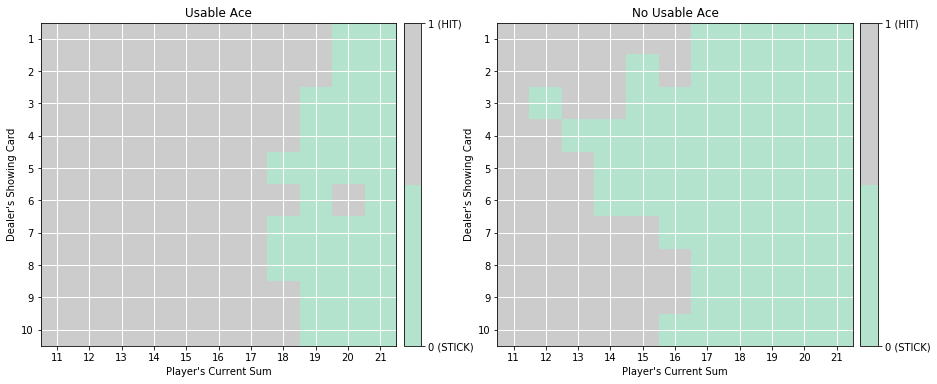

In [17]:
# plot the optimal policy
plot_policy(optimal_policy)

## Time To Play!

In [18]:
num_episodes=1000
score = evaluate_policy(env, optimal_policy, num_episodes=num_episodes)
print(f'Policy Score: {score} (Wins {int(score * num_episodes)} of {num_episodes})')

Now, the agent is playing...
Policy Score: 0.423 (Wins 423 of 1000)


---